# Perceptual loss - Style transfer in a single forward pass

Paper: https://arxiv.org/abs/1603.08155


Idea: Train a transformation network which transforms an input image X into an image X' in the style of a style image S using a single forward pass, without having to solve an optimization problem for each style transfer.

To compute the loss, use a pretrained model which assesses the perceptual quality of the generated image. This essentially evaluates the model in the feature space.



In [ ]:
# Colab stuff
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/MyDrive/GANModels/GANs_Code/experiments/real_time_style_transfer/")

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.layers import Input
from IPython.display import Image, display
from keras.models import load_model

from PIL import Image as ImagePIL
import matplotlib.pyplot as plt
#import seaborn as sb

Init Plugin
Init Graph Optimizer
Init Kernel


# Image preprocessing

Images in:
- Input image X -> image we want to transform
- Content image C -> Image from which we want the content. Isn't that X for style transfer??
- Style image S -> Image which contains the style we want to extract.
  

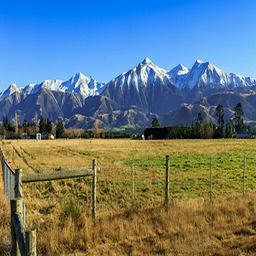

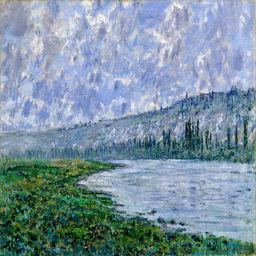

In [54]:
# Load images
# Style images
content_images = ["0cae98323f", "1ece79b77f", "3abca1ec15"]
style_images = ["732d76a469", "853f8d711f", "c7d8142152", "d14c1abdd4", "de6f71b00f", "49337b68f4", "0bd913dbc7"]

content_image = content_images[2]
style_image = style_images[6]

base_path_content = "../../data/art/photo_jpg/"
base_path_style = "../../data/art/monet_jpg/"
content_image_path = base_path_content + content_image + ".jpg"
style_image_path = base_path_style + style_image + ".jpg"
display(Image(content_image_path))
display(Image(style_image_path))

In [62]:
# Make tf dataset from content images.
image_size = (256,256)
batch_size = 1

base_path_content = "../../data/art/photo_jpg/"
base_path_content = "../../data/art/12images/"
base_path_content = "../../data/art/testSmall/"

train = keras.preprocessing.image_dataset_from_directory(
    base_path_content,
    #validation_split=0.99,
    #subset="training",
    labels=None,
    seed=1581,
    image_size=image_size,
    batch_size=batch_size
)


Found 1 files belonging to 1 classes.


In [11]:
# Preprocess and postprocess images
def get_and_scale_image(image_path):
    """
    Loads and scales a .jpg image.
    Returns a tf.tensor with batch dimension, scaled to [0,1].
    """

    image = keras.preprocessing.image.load_img(image_path)
    image = keras.preprocessing.image.img_to_array(image)
    
    # Scale
    image = image / 255.0

    # Adds batch dimension. Shape is (batch, height, width, colour)
    image = np.array([image])

    # Convert to tensorflow tensor
    image = tf.convert_to_tensor(image)

    return image

# Define transform and loss networks

## Transform network
Use Keras Functional API to construct network, since we need the residual blocks.

In [2]:
# Create reflection padding layer
class ReflectionPadding2D(keras.layers.Layer):
    def __init__(self):
        super(ReflectionPadding2D, self).__init__()
    
    def call(self, inputs):
        paddings = tf.constant([[0,0],[40,40],[40,40],[0,0]])

        return tf.pad(inputs, paddings, "REFLECT")

# Residual block
def residual_block(n_filters, name, inputs, stride=(1,1)):
    x = layers.Conv2D(filters=n_filters, kernel_size=(3,3), strides=stride, activation="relu", name='Conv1ResidualBlock_' + name)(inputs)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=n_filters, kernel_size=(3,3), strides=stride, name='Conv2ResidualBlock_' + name)(x)
    x = layers.BatchNormalization(scale=True)(x)

    # Crop the input to match sizes and add activations.
    inputs = tf.keras.layers.Cropping2D(cropping=((2,2),(2,2)), data_format=None)(inputs)
    x = layers.Add()([x, inputs])
    return x


# Test
x = tf.ones(shape=(1,84,84,128))
print(x.shape)

y = residual_block(128,"1", x)
print(y.shape)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

(1, 84, 84, 128)
(1, 80, 80, 128)


2021-12-29 20:58:37.143382: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-29 20:58:37.143598: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Transform net

In [18]:
### Transform network ###
def get_transform_net_deconvs():
    """
    Loads the transformation network.
    """

    inputs = keras.Input(shape=(256,256,3), name="InputLayer")

    # Reflection padding
    padding = ReflectionPadding2D()
    padding._name = "Reflection"
    x = padding(inputs)
   
    x = layers.Conv2D(filters=32, kernel_size=(9,9),strides=(1,1), activation="relu", padding='same', name="Conv1")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv2")(x) 
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv3")(x)
    x = layers.BatchNormalization(scale=True)(x)

    # Residual blocks
    x = residual_block(128,"1", x)
    x = residual_block(128,"2", x)
    x = residual_block(128,"3", x)
    x = residual_block(128,"4", x)
    x = residual_block(128,"5", x)

    # Deconvolutions
    x = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv1")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name='Deconv2')(x)
    x = layers.BatchNormalization(scale=True)(x)

    outputs = layers.Conv2DTranspose(filters=3, kernel_size=(9,9), strides=(1,1), activation="tanh", padding='same', name="Conv4")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="Transform_network")
model = get_transform_net_deconvs()
#model.summary()
    


In [65]:
### Transform network with convs and padding only ###
def get_transform_net_convs_resize():
    """
    Loads the transformation network.
    """

    inputs = keras.Input(shape=(256,256,3), name="InputLayer")

    # Reflection padding
    padding = ReflectionPadding2D()
    padding._name = "Reflection"
    x = padding(inputs)
   
    x = layers.Conv2D(filters=32, kernel_size=(9,9),strides=(1,1), activation="relu", padding='same', name="Conv1")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv2")(x) 
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv3")(x)
    x = layers.BatchNormalization(scale=True)(x)

    # Residual blocks
    x = residual_block(128,"1", x)
    x = residual_block(128,"2", x)
    x = residual_block(128,"3", x)
    x = residual_block(128,"4", x)
    x = residual_block(128,"5", x)

    # Deconvolutions
    x = tf.image.resize(x, size=[257,257], method=tf.image.ResizeMethod.BILINEAR)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='valid', name="Deconv1")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = tf.image.resize(x, size=[514,514], method=tf.image.ResizeMethod.BILINEAR)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='valid', name='Deconv2')(x)
    x = layers.BatchNormalization(scale=True)(x)

    outputs = layers.Conv2D(filters=3, kernel_size=(9,9), strides=(1,1), activation="tanh", padding='same', name="Conv4")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="Transform_network")

transform_network = get_transform_net_convs_resize()
#transform_network.summary()

In [3]:
### Transform network with convs and padding only ###
def get_transform_net_convs_resize_padding():
    """
    Loads the transformation network.
    """

    inputs = keras.Input(shape=(256,256,3), name="InputLayer")

    # Reflection padding
    padding = ReflectionPadding2D()
    padding._name = "Reflection"
    x = padding(inputs)
   
    x = layers.Conv2D(filters=32, kernel_size=(9,9),strides=(1,1), activation="relu", padding='same', name="Conv1")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv2")(x) 
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3,3),strides=(2,2), activation="relu", padding='same', name="Conv3")(x)
    x = layers.BatchNormalization(scale=True)(x)

    # Residual blocks
    x = residual_block(128,"1", x)
    x = residual_block(128,"2", x)
    x = residual_block(128,"3", x)
    x = residual_block(128,"4", x)
    x = residual_block(128,"5", x)

    # Deconvolutions
    paddings = tf.constant([[0,0],[2,2],[2,2],[0,0]])
    x = tf.image.resize(x, size=[253,253], method=tf.image.ResizeMethod.BILINEAR) #257
    x = tf.pad(x, paddings)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='valid', name="Deconv1")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = tf.image.resize(x, size=[510,510], method=tf.image.ResizeMethod.BILINEAR) # 514
    x = tf.pad(x, paddings)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='valid', name='Deconv2')(x)
    x = layers.BatchNormalization(scale=True)(x)

    outputs = layers.Conv2D(filters=3, kernel_size=(9,9), strides=(1,1), activation="tanh", padding='same', name="Conv4")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="Transform_network")

transform_network = get_transform_net_convs_resize_padding()
#transform_network.summary()

### Medium net

In [66]:
### Smaller test model
def get_medium_model_deconvs():
    inputs = keras.Input(shape=(256,256,3), name="InputLayer")
    
    x = layers.Conv2D(filters=32, kernel_size=(9,9), strides=(1,1), activation="relu", padding='same', name="Conv1")(inputs)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Conv2")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Conv3")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv1")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv2")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2DTranspose(filters=3, kernel_size=(9,9), strides=(1,1), padding='same', name="Deconv3")(x) 
    outputs = activations.tanh(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="Medium_network_deconvs")

test_model = get_medium_model_deconvs()
#test_model.summary()

In [8]:
### Smaller test model
def get_medium_model_convs():
    inputs = keras.Input(shape=(256,256,3), name="InputLayer")
    
    x = layers.Conv2D(filters=32, kernel_size=(9,9), strides=(1,1), activation="relu", padding='same', name="Conv1")(inputs)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Conv2")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=128, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Conv3")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = tf.image.resize(x, [256,256], method=tf.image.ResizeMethod.BILINEAR)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv1")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = tf.image.resize(x, [512,512], method=tf.image.ResizeMethod.BILINEAR)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv2")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=3, kernel_size=(9,9), strides=(1,1), padding='same', name="Deconv3")(x) 
    outputs = activations.tanh(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="Medium_network_convs")

test_model = get_medium_model_convs()
#test_model.summary()

### Small network

In [10]:
### Smaller test model
def get_test_model():
    inputs = keras.Input(shape=(256,256,3), name="InputLayer")
    
    x = layers.Conv2D(filters=32, kernel_size=(9,9), strides=(1,1), activation="relu", padding='same', name="Conv1")(inputs)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Conv2")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2), activation="relu", padding='same', name="Deconv1")(x)
    x = layers.BatchNormalization(scale=True)(x)

    x = layers.Conv2DTranspose(filters=3, kernel_size=(9,9), strides=(1,1), padding='same', name="Deconv2")(x) 
    outputs = activations.tanh(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="Test_network")

test_model = get_test_model()
#test_model.summary()

## Loss network
Use pretrained VGG16.

In [30]:
# Loss network
# Input: 224x224 -> Do I have to resize the input image from 256x256 or does the model not care?
loss_net = vgg16.VGG16(include_top=False, weights="imagenet", input_tensor=Input(shape=(256,256,3)))
loss_net_outputs = dict([(layer.name, layer.output) for layer in loss_net.layers])

loss_net_activations = keras.Model(inputs=loss_net.inputs, outputs=loss_net_outputs)
#loss_net.summary()

# Define loss function

In [31]:
# Hashtables: layer -> [height, width, channels]

style_layers = {
    "block1_conv2": [256,256,64],
    "block2_conv2": [128,128,128],
    "block3_conv3": [64,64,256],
    "block4_conv3" : [32,32,512]
}
content_layers = {"block3_conv3": [64,64,256]}

In [32]:
# Feature loss (content loss)

# Define input image shape
channels = 3
height = 256
width = 256

def compute_content_loss(generated, content, dimensions):
    """
    Computes the content loss from the given features.
    Equation 2 in paper.

    Args:
    generated:  Tensor feature map of the generated image.
    content:    Tensor feature map of the content image.
    dimensions: List of layer dimensions [height, width, channels]
    """
    # Check dimensions
    assert generated.shape[0] == content.shape[0], "Batch dimensions of generated and content image don't match!"

    height, width, channels = dimensions[0], dimensions[1], dimensions[2]
    scaling_factor = (int(height/4) * int(width/4) * channels) # H, W, C

    # Sum over all elements, including the batch_size to get average loss over the batch.
    content_reconstruction_loss =  tf.math.reduce_sum(tf.square(generated - content)) / (scaling_factor * generated.shape[0])
    return content_reconstruction_loss


def gram_matrix(x):
    """
    Computes the gram matrix with batch dimension.
    
    y = xT * x

    Inputs:
    x  -- tf.tensor with batch dimension (batch_dim, x1, x2, x3)
    """
    x = tf.transpose(x, (0,3,1,2))
    features = tf.reshape(x, (tf.shape(x)[0], tf.shape(x)[1], -1))
    gram = tf.matmul(features, tf.transpose(features, (0,2,1)))
    return gram


# TODO: Add batch size
def compute_style_loss(generated, style, dimensions):
    """
    Compute style loss for one layer.
    """
    
    # Dimensions
    height, width, channels = dimensions[0], dimensions[1], dimensions[2] 
    scaling_factor = (channels * height * width)**2
    generated = gram_matrix(generated)
    style = gram_matrix(style)

    # Compute the total average loss over all elements in the batch.
    res = tf.reduce_sum(tf.square(generated - style)) / (scaling_factor * generated.shape[0])
    return res



### TEST: Gram matrix
x1 = tf.ones(shape=(1,2,2,3)) * 2
x2 = tf.ones(shape=(1,2,2,3)) * 3
x = tf.concat([x1, x2], 0)
y = gram_matrix(x)


In [33]:
# TODO: Add Total Variation Regularization?
def compute_perceptual_loss(generated_image, content_image, style_image):
    """
    Computes the loss with the loss network.

    Args:
    tf.tensors, scaled to [0,1] with dim (b,h,w,c), RGB.
    """
    # Weight factors. Paper uses ratios of 10e-3 and 10e-4.
    lambda_feature = 0.001
    lambda_style = 1

    # Combine input tensors to make one pass with all in parallel.
    input_tensors = tf.concat([generated_image, content_image, style_image], axis=0)

    # Preprocess input_tensors for vgg16. Expects range [0, 255]
    input_tensors = tf.keras.applications.vgg16.preprocess_input(input_tensors*255)

    # Forward pass to get loss from loss network.
    features = loss_net_activations(input_tensors, training=False)

    # Initialize loss
    loss_feature = tf.zeros(shape=())
    loss_style = tf.zeros(shape=())

    # Compute content loss
    for content_layer in content_layers.keys():
        layer_features = features[content_layer]
        generated_features = layer_features[0:batch_size,:,:,:]
        content_features = layer_features[batch_size:batch_size*2,:,:,:]
        loss_feature += compute_content_loss(generated_features, content_features, content_layers[content_layer])

    # Compute style loss
    for style_layer in style_layers.keys():
        layer_features = features[style_layer]
        generated_features = layer_features[0:batch_size,:,:,:]
        style_features = layer_features[2*batch_size,:,:,:]
        style_features = tf.expand_dims(style_features, 0)
        loss_style += compute_style_loss(generated_features, style_features, style_layers[style_layer])


    return (loss_feature * lambda_feature + loss_style * lambda_style)

In [5]:
# Pixel loss
def compute_pixel_loss(generated_image, content_image, style_image):
    for img in content_image:
        print(tf.math.reduce_min(img), tf.math.reduce_max(img))
        break
    return tf.reduce_sum(tf.square(content_image - generated_image))


In [15]:
# Uninitialized models

# Transform models
#transform_network = get_transform_net_deconvs()
#transform_network = get_transform_net_convs_resize()
transform_network = get_transform_net_convs_resize_padding()

# Medium models
#transform_network = get_medium_model_deconvs()
#transform_network = get_medium_model_convs()
#transform_network = get_medium_model_more_convs()

# Mini models


# Load weights
#transform_network.load_weights("models/debug/miniNetworkOpt_2images_c7d8142152_batchsize1_epochs500.h5")
transform_network.load_weights("models/transformNetConvsPadding_all_0bd913dbc7_batchsize4_epochs100.h5")
#transform_network.load_weights("models/transformNetworkDeconvs_all_0bd913dbc7_batchsize1_epochs100.h5")




@tf.function
def compute_loss_and_grads(content_image, style_image):
    """
    Takes in content and style images as tf.tensors with batch dimension
    and scaled to range [0,1].
    """
    
    with tf.GradientTape() as tape:

        # Forward pass
        generated_image = transform_network(content_image, training=True)
        
        # Convert to range [0,1]
        generated_image = ((generated_image * 0.5) + 0.5)

        # Get loss
        #loss = compute_perceptual_loss(generated_image, content_image, style_image)
        loss = compute_pixel_loss(generated_image, content_image, style_image)

    # Get gradients and upate weights
    grads = tape.gradient(loss, transform_network.trainable_weights)
    optimizer.apply_gradients(zip(grads, transform_network.trainable_weights))
    return loss

## Build training loop


In [70]:
#### AUTOMATED  LOOP
epochs = 1000    # TOTAL
epochs_ran = 0
save_epoch_interval = epochs


model_subfolder = "debug"
dataset_name = "testSmall"
network_architecture_name = "mediumNetConvs"
num_samples = len(train)




optimizer = keras.optimizers.Adam(learning_rate=0.001)
## Custom training loop from scratch

# Load style image
print("Loading style image...")
style_image_name = "0bd913dbc7" # "c7d8142152" # "49337b68f4" #"853f8d711f" #"732d76a469"

# Load style image as tf.tensor, scaled.
style_image = get_and_scale_image("../../data/art/monet_jpg/"+style_image_name+".jpg")

for epoch in range(epochs_ran, epochs):
    print("Running epoch %d / %d" %(epoch+1, epochs))
    for step, img in enumerate(train):
        
        # Scale image to range [0,1]
        img = img / 255.0

        loss = compute_loss_and_grads(img, style_image)
        
        # Print current batch-wise loss
        if step > 10 and step % int(num_samples//10) == 0 or step <= 10:
            print("Current loss for one batch at step {:.0f}: {:.2f}".format(step, loss))

    if ((epoch+1) % save_epoch_interval == 0):
        # Name format: <networkArchitecure>_<dataSet>_<style_image>_batchsize<batchSize>_epochs<numEpochs>
        transform_network.save_weights("models/"+model_subfolder+"/"+network_architecture_name+"_"+dataset_name+"_"+style_image_name+"_batchsize"+str(batch_size)+"_epochs"+str(epoch+1)+".h5", save_format='h5')
        print("Saved latest model at epoch", epoch+1)

# Save final model. Format: <style_image>_epochs<numEpochs>_batchSize<numBatchSize>_<dataSet> 
transform_network.save_weights("models/"+model_subfolder+"/"+network_architecture_name+"_"+dataset_name+"_"+style_image_name+"_batchsize"+str(batch_size)+"_epochs"+str(epoch+1)+".h5", save_format='h5')

Loading style image...
Running epoch 1 / 1000
Tensor("while/Min:0", shape=(), dtype=float32) Tensor("while/Max:0", shape=(), dtype=float32)
Tensor("while/Min:0", shape=(), dtype=float32) Tensor("while/Max:0", shape=(), dtype=float32)


2021-12-27 13:56:01.844390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Current loss for one batch at step 0: 31616.10
Running epoch 2 / 1000
Current loss for one batch at step 0: 17719.08
Running epoch 3 / 1000
Current loss for one batch at step 0: 16163.65
Running epoch 4 / 1000
Current loss for one batch at step 0: 13335.70
Running epoch 5 / 1000
Current loss for one batch at step 0: 13027.52
Running epoch 6 / 1000
Current loss for one batch at step 0: 9571.48
Running epoch 7 / 1000
Current loss for one batch at step 0: 7651.64
Running epoch 8 / 1000
Current loss for one batch at step 0: 6936.53
Running epoch 9 / 1000
Current loss for one batch at step 0: 6030.92
Running epoch 10 / 1000
Current loss for one batch at step 0: 5396.68
Running epoch 11 / 1000
Current loss for one batch at step 0: 4762.33
Running epoch 12 / 1000
Current loss for one batch at step 0: 4531.26
Running epoch 13 / 1000
Current loss for one batch at step 0: 3794.10
Running epoch 14 / 1000
Current loss for one batch at step 0: 3849.58
Running epoch 15 / 1000
Current loss for one ba

## Show results

In [20]:
def show_image(image_name, style=False):
    """
    Displays selected image.
    """
    if style == False:
        base_path = "../../data/art/photo_jpg/"
    else:
        base_path = "../../data/art/monet_jpg/"

    image = keras.preprocessing.image.load_img(base_path + image_name + ".jpg")
    display(image)

In [6]:
def generate_image(image_name, filename=None):
    """
    Runs inference with selected image and displays result.
    """
    
    base_path = "../../data/art/photo_jpg/"

    image = keras.preprocessing.image.load_img(base_path + image_name + ".jpg")  
    image = keras.preprocessing.image.img_to_array(image)
    
    # Scale
    image = image / 255.0

    # Adds batch dimension. Shape is (batch, height, width, colour)
    image = np.array([image])

    # Convert to tensorflow tensor
    image = tf.convert_to_tensor(image)   
    generated_image = transform_network(image, training=False)
    tf.print(tf.math.reduce_min(generated_image), tf.math.reduce_max(generated_image))

    generated_image = generated_image.numpy()
    generated_image = ((generated_image * 0.5) + 0.5) 
    generated_image = generated_image * 255

    # Remove batch dimension
    generated_image = generated_image.reshape((256,256,3))

    print(generated_image.min(), generated_image.max())

    img = ImagePIL.fromarray(np.uint8(generated_image)).convert('RGB')
    display(img)
    if filename != None:
        # Used filenames: <content_image>-<style_image>_batchSize_epochs
        img.save("generatedImages/testLarge/" + filename + ".png")
    return generated_image


### Dataset testLarge

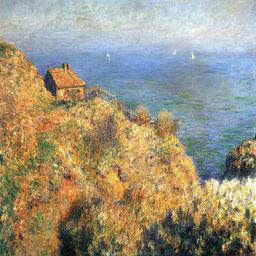

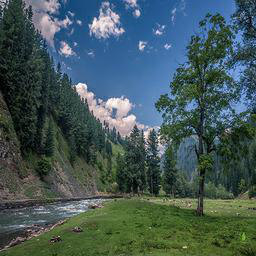

In [21]:
# Style image
show_image("853f8d711f", style=True)

# Content
show_image("0cae98323f")

-1 0.898685694
0.0 242.08243


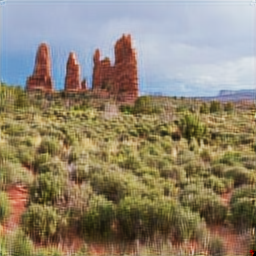

In [20]:
# Transfer model with deconvs, 500 epochs
content_images = ["0cae98323f", "1ece79b77f", "1f1a19ad8b", "3abca1ec15", "0a996d988b"]
test_image = content_images[4]
data = generate_image(test_image)

-0.960599184 0.932318926
5.023604 246.37067


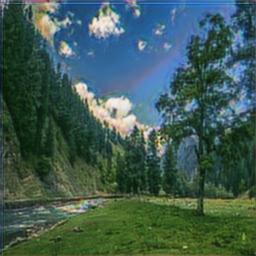

In [15]:
# Test model no deconvs (except last layer), 500 epochs
# Content: 3abca1ec15
test_image = "0cae98323f"
data = generate_image(test_image)

-0.978169143 0.992998242
2.7834342 254.10727


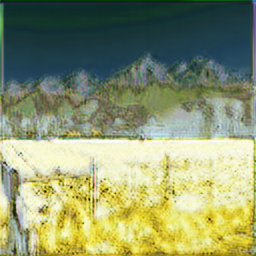

In [114]:
test_image = "3abca1ec15"
data = generate_image(test_image)

-0.983736813 0.952153444
2.0735564 248.89957


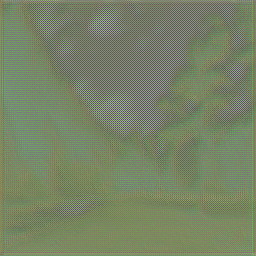

In [28]:
# Baseline
test_image = "0cae98323f"
data = generate_image(test_image)
#sb.histplot(data.reshape(-1))

-1 1.00000012
0.0 255.0


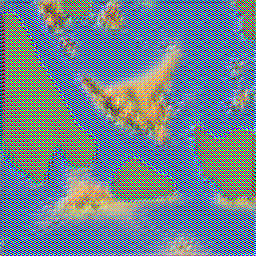

<AxesSubplot:ylabel='Count'>

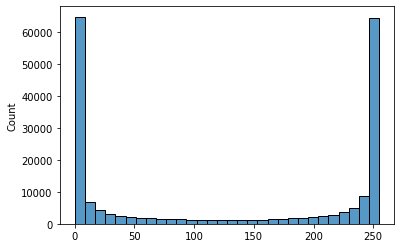

In [66]:
# Style: "853f8d711f" Batchsize: 1 Epochs: 200
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

-1 1.00000012
0.0 255.0


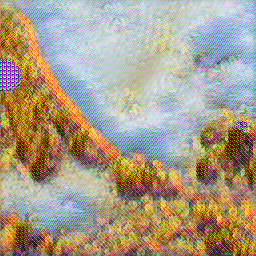

<AxesSubplot:ylabel='Count'>

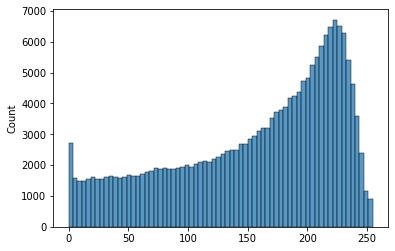

In [16]:
# Style: "853f8d711f" Batchsize: 1 Epochs: 300
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

-1 1.00000012
0.0 255.0


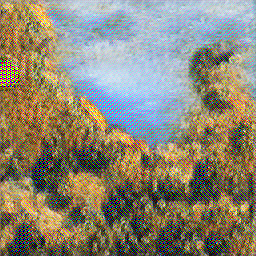

<AxesSubplot:ylabel='Count'>

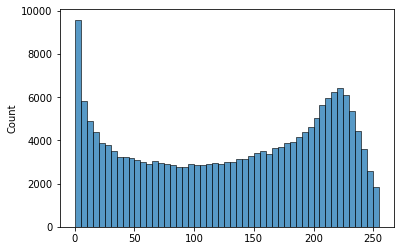

In [18]:
# Style: "853f8d711f" Batchsize: 1 Epochs: 400
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

-1 1.00000012
0.0 255.0


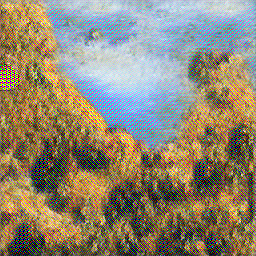

<AxesSubplot:ylabel='Count'>

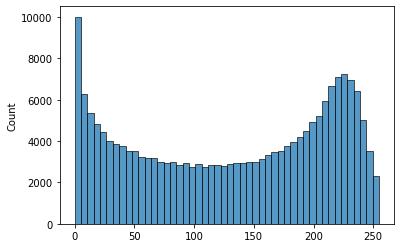

In [20]:
# Style: "853f8d711f" Batchsize: 1 Epochs: 500
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

-1 1.00000012
0.0 255.0


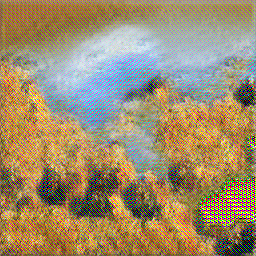

In [22]:
test_image = "1f8b43823c"
data = generate_image(test_image)

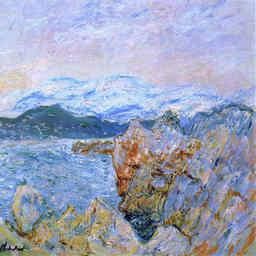

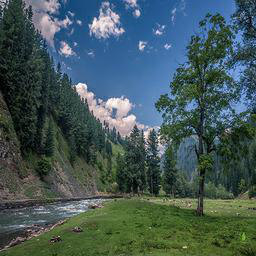

In [64]:
# Style image
show_image("732d76a469", style=True)

# Content
show_image("0cae98323f")

In [ ]:
# Style: "732d76a469" Batchsize: 1 Epochs: 300
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

In [ ]:
# Style: "732d76a469" Batchsize: 1 Epochs: 400
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))

In [ ]:
# Style: "732d76a469" Batchsize: 1 Epochs: 500
test_image = "0cae98323f"
data = generate_image(test_image)
sb.histplot(data.reshape(-1))